# sprint10課題 深層学習スクラッチニューラルネットワーク

NumPyなど最低限のライブラリのみを使いアルゴリズムを実装していきます。  

今回は多クラス分類を行う3層のニューラルネットワークを作成します。  
層の数などは固定した上でニューラルネットワークの基本を確認しましょう。次のSprintで層を自由に変えられる設計にしていきます。  

### データセットの用意

MNISTデータセットを使用します。  
以下のコードを実行すればKerasによりデータセットをダウンロードし、展開まで行えます。

### MNISTとは？

画像分類のための定番データセットで、手書き数字認識を行います。  
このデータセットには学習用6万枚、テスト用1万枚の28×28ピクセルの白黒画像、およびそれらが0〜9のどの数字であるかが含まれています。  

### 画像データとは？  

デジタル画像は点の集合で、これをピクセルと呼びます。  
一般的に白黒画像であればピクセルには0〜255の値が含まれます。  
一方、カラー画像であればR（赤）、G（緑）、B（青）それぞれに対応する0〜255の値が含まれます。  
機械学習をする上では、この0〜255の値一つひとつが特徴量として扱われます。  
0〜255は符号なしの8ビット整数で表せる範囲になるため、NumPyであれば「uint8」型の変数として保持できます。  

### データセットの確認  
まず、どういったデータなのかを見てみます。

## 平滑化  

(1, 28, 28)の各画像を、(1, 784)に変換します。  
これまで学んできた機械学習手法や、今回扱う全結合層のみのニューラルネットワークではこの形で扱います。  
全てのピクセルが一列になっていることを、平滑化（flatten）してあるという風に表現します。

In [1]:
from tqdm import tqdm_notebook as tqdm
import pyprind
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

Using TensorFlow backend.


In [3]:
print(x_train.shape) # (60000, 28, 28)
print(x_test.shape) # (10000, 28, 28)
print(x_train[0].dtype) # uint8
print(x_train[0])

(60000, 28, 28)
(10000, 28, 28)
uint8
[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   3  18  18  18 126 136
  175  26 166 255 247 127   0   0   0   0]
 [  0   0   0   0   0   0   0   0  30  36  94 154 170 253 253 253 253 253
  225 172 253 242 195  64   0   0   0   0]
 [  0   0   0   0   0   0   0  49 238 253 253 253 253 253 253 253 253 251
   93  82  82  56  39   0   0   0   0   0]
 [  0   0   0   0   0   0 

In [4]:
X_train = x_train.reshape(-1, 784)
X_test = x_test.reshape(-1, 784)

## 画像データの可視化

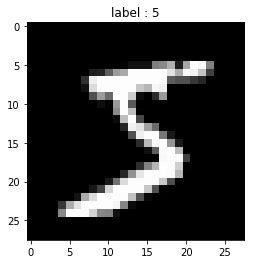

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
index = 0
image = X_train[index].reshape(28,28)
# X_train[index]: (784,)
# image: (28, 28)
plt.imshow(image, 'gray')
plt.title('label : {}'.format(y_train[index]))
plt.show()

画像データは符号なし8ビット整数のuint8型で保持されることが一般的ですが、plt.imshowはより自由な配列を画像として表示することが可能です。  
例えば、以下のようにマイナスの値を持ったfloat64型の浮動小数点であってもエラーにはならないし、先ほどと全く同じ風に表示されます。

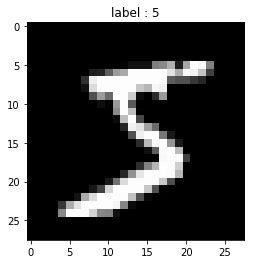

[[-105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35
  -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35
  -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35
  -105.35]
 [-105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35
  -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35
  -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35
  -105.35]
 [-105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35
  -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35
  -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35
  -105.35]
 [-105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35
  -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35
  -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35
  -105.35]
 [-105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -1

In [6]:
index = 0
image = X_train[index].reshape(28,28)
image = image.astype(np.float) # float型に変換
image -= 105.35 # 意図的に負の小数値を作り出してみる
plt.imshow(image, 'gray')
plt.title('label : {}'.format(y_train[index]))
plt.show()
print(image) # 値を確認

これは、自動的に値を0〜255の整数に変換して処理するように作られているからです。  
uint8型であっても最小値が0、最大値が255でない場合には色合いがおかしくなります。それを防ぐためには次のように引数を入れてください。

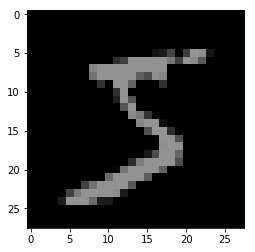

In [7]:
plt.imshow(image, 'gray', vmin = 0, vmax = 255)

### 前処理
画像は0から255のuint8型で表されますが、機械学習をする上では0から1のfloat型で扱うことになります。  
色は理想的には連続値であり、それを特徴量とするからです。以下のコードで変換可能です。

In [8]:
X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)
X_train /= 255
X_test /= 255
print(X_train.max()) # 1.0
print(X_train.min()) # 0.0

1.0
0.0


また、正解ラベルは0から9の整数ですが、ニューラルネットワークで多クラス分類を行う際にはone-hot表現に変換します。  
scikit-learnのOneHotEncoderを使用したコードが以下です。このone-hot表現による値はそのラベルである確率を示していることになるため、float型で扱います。

In [9]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_train_one_hot = enc.fit_transform(y_train[:, np.newaxis])
y_test_one_hot = enc.transform(y_test[:, np.newaxis])
print(y_train.shape) # (60000,)
print(y_train_one_hot.shape) # (60000, 10)
print(y_train_one_hot.dtype) # float64

(60000,)
(60000, 10)
float64


In [10]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train_one_hot, test_size=0.2)
print(X_train.shape) # (48000, 784)
print(X_val.shape) # (12000, 784)

(48000, 784)
(12000, 784)


# 【問題1】ニューラルネットワーク分類器のクラスを作成  
ニューラルネットワーク分類器のクラスScratchSimpleNeuralNetrowkClassifierを作成してください。

### ミニバッチ処理

これまでの機械学習スクラッチでは、全てのサンプルを一度に計算していました。  
しかし、ニューラルネットワークではデータを分割して入力する確率的勾配降下法が一般的です。  
分割した際のひとかたまりをミニバッチ、そのサンプル数をバッチサイズと呼びます。  

今回はバッチサイズを20とします。今回使う学習用データは48000枚ですから、48000/20で2400回の更新を繰り返すことになります。  
ニューラルネットワークではこれを2400回イテレーション（iteration）すると呼びます。  
学習データを一度全て見ると1回のエポック（epoch）が終わったことになります。このエポックを複数回繰り返し、学習が完了します。

これを実現するための簡素なイテレータを用意しました。for文で呼び出すと、ミニバッチを取得できます。

In [11]:
class GetMiniBatch:
    """
    ミニバッチを取得するイテレータ

    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
      学習データ
    y : 次の形のndarray, shape (n_samples, 1)
      正解値
    batch_size : int
      バッチサイズ
    seed : int
      NumPyの乱数のシード
    """
    def __init__(self, X, y, batch_size = 10, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self.X = X[shuffle_index]
        self.y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)

    def __len__(self):
        return self._stop

    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self.X[p0:p1], self.y[p0:p1]        

    def __iter__(self):
        self._counter = 0
        return self

    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self.X[p0:p1], self.y[p0:p1]

In [12]:
# 以下をニューラルネットワークのクラス内で呼び出す

get_mini_batch = GetMiniBatch(X_train, y_train, batch_size=10)

print(len(get_mini_batch)) # 4800
print(get_mini_batch[5])

4800
(array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]]), array([[0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]]))


# クラス作成

In [2]:
class ScratchSimpleNeuralNetrowkClassifier():
    """
    シンプルな三層ニューラルネットワーク分類器

    Parameters
    ----------

    Attributes
    ----------
    """

    def __init__(self,
                 verbose=True,
                 act_func='sigmoid',
                 batch_size=10,
                 e_threshold=0.01,
                 n_epoch=100,
                 lr=1e-2):
        self.verbose = verbose
        self.n_features = 784
        self.n_nodes1 = 400
        self.n_nodes2 = 200
        self.n_output = 10
        self.sigma = 0.01
        self.act_func = act_func    
        self.e_threshold = e_threshold     
        self.batch_size = batch_size
        self.entropys = []
        self.val_entropys = []
        self.n_epoch = n_epoch
        self.lr = lr  # 学習率
    
    def _linear_sum(self, X, W, B):
        """
        線形和をする関数。
        X : 次の形のndarray, shape (batch_size, n_features)
          学習データ
        W : 次の形のndarray, shape (n_features, n_nodes1)
          重み
        B : 次の形のndarray, shape (n_nodes1,)

        ----------------------------
        return
        次の形のndarray, shape (batch_sizes, n_nodes1)
        """
        return X @ W + B

    def _sigmoid(self, A):
        return 1 / (1 + np.exp(-A))

    def _hyperbolic_tanh(self, A):
        return np.tanh(A)

    def _soft_max(self, A):
        c = np.max(A)
        return np.exp(A - c) / np.sum(np.exp(A - c), axis=1).reshape(-1, 1)

    def _entropy_calc(self, Z, Y):
        errors = -np.sum(Y * np.log(Z + 1e-5), axis=1)
        return errors.sum() / len(errors)  # スカラー値

    def forward_propagation(self, X):
        A1 = self._linear_sum(X, self.W1, self.B1)
        Z1 = self._sigmoid(A1)
        A2 = self._linear_sum(Z1, self.W2, self.B2)
        Z2 = self._sigmoid(A2)
        A3 = self._linear_sum(Z2, self.W3, self.B3)
        Z3 = self._soft_max(A3)
        return A1, A2, Z1, Z2, Z3

    def _layer_grads_calc(self, z_grads, z, a, w, lastlayer=False):
        """
        １つの層の勾配を計算する関数
        最後の層の場合はz_gradsはzを、aにはyを入力する。
        """
        # 出力層の場合
        if lastlayer == True:
            a_grads = z_grads - a
        # 違う層の場合、sigmoidとhypo
        else:
            if self.act_func == 'sigmoid':
                a_grads = z_grads * (1 - self._sigmoid(a)) * self._sigmoid(a)
            elif self.act_func == 'hytan':
                a_grads = z_grads * (1 - self._tanh(a)**2)
        b_grads = a_grads
        w_grads = z.T @ a_grads
        z_grads = a_grads @ w.T
        return b_grads, w_grads, z_grads

    def _back_propagation(self, X, Y, A1, A2, Z1, Z2, Z3):
        # 3層目
        B3_grads, W3_grads, Z2_grads = self._layer_grads_calc(Z3,
                                                              Z2,
                                                              Y,
                                                              self.W3,
                                                              lastlayer=True)
        B2_grads, W2_grads, Z1_grads = self._layer_grads_calc(Z2_grads,
                                                              Z1,
                                                              A2,
                                                              self.W2,
                                                              lastlayer=False)
        B1_grads, W1_grads, _ = self._layer_grads_calc(Z1_grads,
                                                       X,
                                                       A1,
                                                       self.W1,
                                                       lastlayer=False)
        # 重みの更新
        self.W1, self.W2, self.W3 = self.W1 - self.lr * (W1_grads / self.batch_size), self.W2 - \
            self.lr * (W2_grads / self.batch_size), self.W3 - \
            self.lr * (W3_grads / self.batch_size)

        self.B1, self.B2, self.B3 = self.B1 - self.lr * np.mean(B1_grads, axis=0), self.B2 - \
            self.lr * np.mean(B2_grads, axis=0), self.B3 - \
            self.lr * np.mean(B3_grads, axis=0)
        return self

    def fit(self, X, y, X_val=None, y_val=None):
        """
        ニューラルネットワーク分類器を学習する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            学習用データの特徴量
        y : 次の形のndarray, shape (n_samples, )
            学習用データの正解値
        X_val : 次の形のndarray, shape (n_samples, n_features)
            検証用データの特徴量
        y_val : 次の形のndarray, shape (n_samples, )
            検証用データの正解値
        """

        # 重み、バイアスの初期化
        self.W1 = self.sigma * np.random.randn(self.n_features, self.n_nodes1)
        self.W2 = self.sigma * np.random.randn(self.n_nodes1, self.n_nodes2)
        self.W3 = self.sigma * np.random.randn(self.n_nodes2, self.n_output)
        self.B1 = self.sigma * np.random.randn(self.n_nodes1)
        self.B2 = self.sigma * np.random.randn(self.n_nodes2)
        self.B3 = self.sigma * np.random.randn(self.n_output)

        self.entropys = []  # 誤差を入れるリストを用意
        onehot_y = np.eye(len(np.unique(y)))[np.array(y).flatten()].astype(
            "int")  # yをワンホットエンコーディングする
        get_mini_batch = GetMiniBatch(X, onehot_y,
                                      batch_size=self.batch_size)  # バッチに分ける。
        if X_val is not None:
            onehot_y_val = np.eye(
                len(np.unique(y_val)))[np.array(y_val).flatten()].astype(
                    "int")  # yをワンホットエンコーディングする
            self.val_entropys = []  # 誤差を入れるリストを用意

        pbar = pyprind.ProgBar(self.n_epoch)  # 学習開始
        for epoch in range(self.n_epoch):
            for mini_X_train, mini_y_train in get_mini_batch:
                # まずはXに対してフォワードプロパゲーションする。
                A1, A2, Z1, Z2, Z3 = self.forward_propagation(mini_X_train)
                # 出力に対する誤差によって、重みを更新（バックプロパゲーション）
                self._back_propagation(mini_X_train, mini_y_train, A1, A2, Z1,
                                       Z2, Z3)
            # エントロピーを計算するためXを予測
            Z3 = self.forward_propagation(X)[4]
            self.entropys.append(self._entropy_calc(
                Z3, onehot_y))  # 1サンプル毎の平均誤差をリストに格納
            if X_val is not None:
                Z3_val = self.forward_propagation(X_val)[4]
                self.val_entropys.append(
                    self._entropy_calc(Z3_val, onehot_y_val))

            if self.entropys[epoch] < self.e_threshold:  # 誤差が閾値以下ならエポック終了
                print('entropyが{.3f}より低い！'.format(self.e_threshold))
                break
            pbar.update()

    def predict(self, X):
        """
        ニューラルネットワーク分類器を使い推定する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            サンプル

        Returns
        -------
            次の形のndarray, shape (n_samples, 1)
            推定結果
        """
        pred = self.forward_propagation(X)[4]
        return np.argmax(pred, axis=1)

In [14]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
X_train = x_train.reshape(-1, 784)
X_test = x_test.reshape(-1, 784)

In [15]:
X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)
X_train /= 255
X_test /= 255

In [16]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)
print(X_train.shape) # (48000, 784)
print(X_val.shape) # (12000, 784)

(48000, 784)
(12000, 784)


In [17]:
snn = ScratchSimpleNeuralNetrowkClassifier(n_epoch=30,lr=1e-2)
snn.fit(X_train, y_train,X_val, y_val)

0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:04:05


# 【問題2】学習曲線のプロット

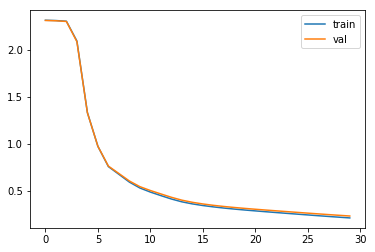

In [18]:
import matplotlib.pyplot as plt
plt.plot(snn.entropys, label='train')
plt.plot(snn.val_entropys,label='val')
plt.legend()
plt.show()

# 【問題3】指標値の算出

In [19]:
pred = snn.predict(X_test)
print('accuracy={:.4f}'.format(accuracy_score(y_test, pred)))

accuracy=0.9350


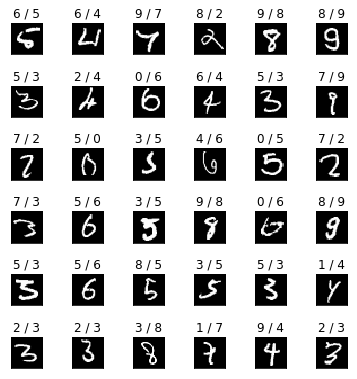

In [20]:
"""
語分類結果を並べて表示する。画像の上の表示は「推定結果/正解」である。

Parameters:
----------
y_pred : 推定値のndarray (n_samples,)
y_val : 検証用データの正解ラベル(n_samples,)
X_val : 検証用データの特徴量（n_samples, n_features)
"""

num = 36 # いくつ表示するか

true_false = pred==y_test
false_list = np.where(true_false==False)[0].astype(np.int)

if false_list.shape[0] < num:
    num = false_list.shape[0]
fig = plt.figure(figsize=(6, 6))
fig.subplots_adjust(left=0, right=0.8,  bottom=0, top=0.8, hspace=1, wspace=0.5)
for i in range(num):
    ax = fig.add_subplot(6, 6, i + 1, xticks=[], yticks=[])
    ax.set_title("{} / {}".format(pred[false_list[i]],y_test[false_list[i]]))
    ax.imshow(X_test.reshape(-1,28,28)[false_list[i]], cmap='gray')